## BIG DATA AND MACHINE LEARNING: TOOLS FOR MAINTENANCE MANAGEMENT

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

### READ ERP DATA FILE

In [2]:
ERP_data=pd.read_csv("ERP_Dataset.csv")
ERP_data.head(2)

,Dates,Part_01,Part_03,Part_05,Part_06,Part_10,Part_12
0,2016-06-01,77.0,23.0,56.0,49.0,111.0,59.0
1,2016-07-01,144.0,40.0,66.0,79.0,167.0,123.0


Text(0.5, 1.0, 'Part 10, Part 12')

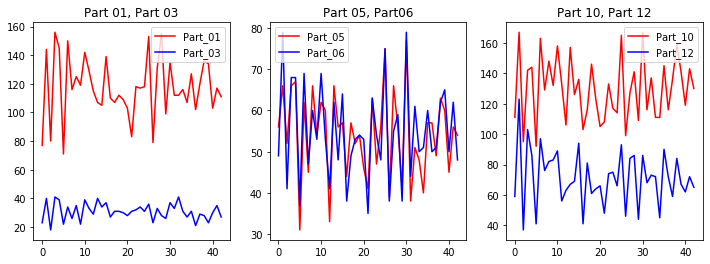

In [3]:
Parts = list(ERP_data.columns)
ERP_data.reset_index()

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
ERP_data.plot(y =Parts[1:3], ax=axes[0], color=['red', 'blue']); axes[0].set_title('Part 01, Part 03')
ERP_data.plot(y =Parts[3:5], ax=axes[1], color=['red', 'blue']); axes[1].set_title('Part 05, Part06')
ERP_data.plot(y =Parts[5:7], ax=axes[2], color=['red', 'blue']); axes[2].set_title('Part 10, Part 12')

### READ MERGE DATA MTBF

In [4]:
MTBF_Data=pd.read_csv("MTBF_Dataset.csv")
m_columns = ['Dates', 'Equipment'] + list(MTBF_Data.columns)[2:]
MTBF_Data = MTBF_Data.reindex(columns = m_columns)
MTBF_Data.head(2)

,Dates,Equipment,Work Shift,Part_01,Part_03,Part_05,Part_06,Part_10,Part_12
0,2019-01-05,3,False,16.0,4.0,4.0,6.0,16.0,10.0
1,2019-01-06,11,False,10.0,3.0,6.0,6.0,16.0,6.0


### PAIRWISE RELATIONSHIPS IN MTBF DATASET

Text(0.5, 0.98, 'Relation between Equipment and Part 05')

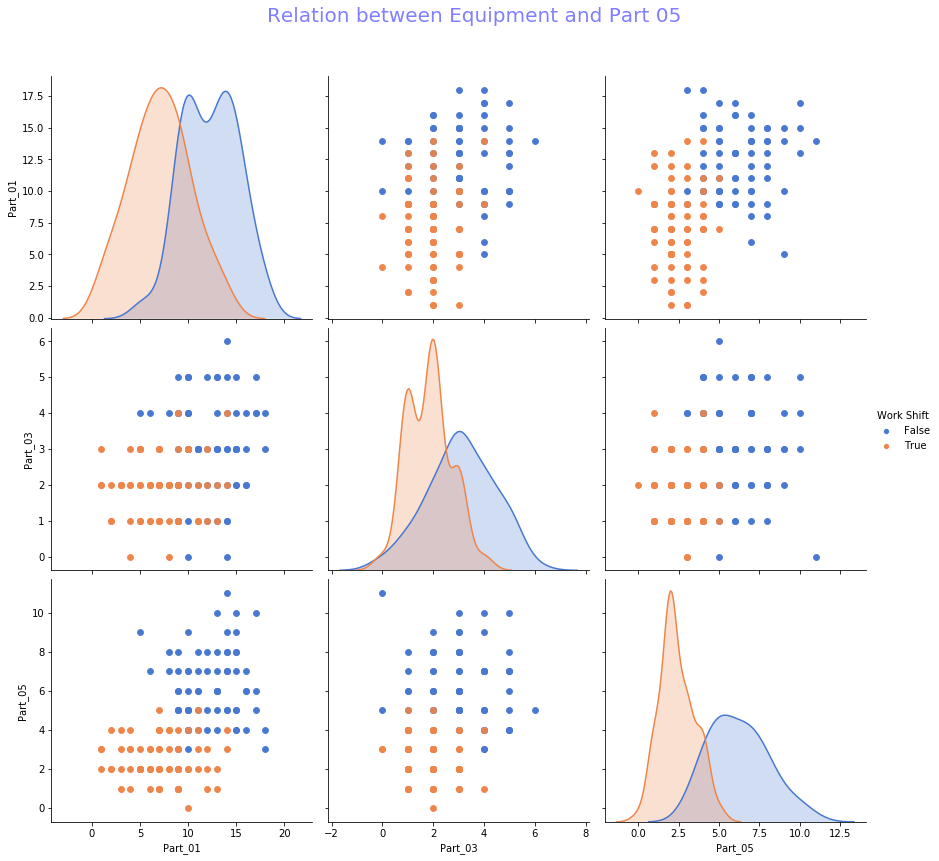

In [5]:
#Create a pairplot(plot across different attributes)
a=sns.pairplot(MTBF_Data,hue='Work Shift' ,palette="muted",height=4,vars=Parts[1:4],kind='scatter',markers=['o','o'])

#Change the size of scatterpoints
a=a.map_offdiag(plt.scatter,s=35,alpha=0.9)

#Remove the top and the right lines
sns.despine()

#Additional line to adjust some appearance issues
plt.subplots_adjust(top=0.9)

#Set the title of the graph
a.fig.suptitle('Relation between Equipment and Part 05',fontsize=20,color='b',alpha=0.5)

### OTHER PAIRWISE RELATIONSHIPS REPRESENTATION

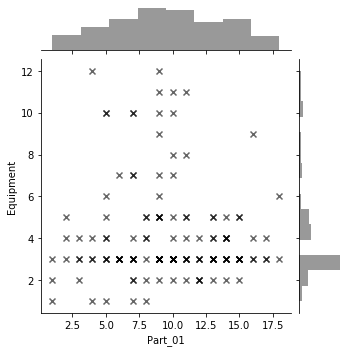

In [6]:
b=sns.jointplot(x='Part_01', y='Equipment', data=MTBF_Data, height=5, alpha=.6,color='k', marker='x')

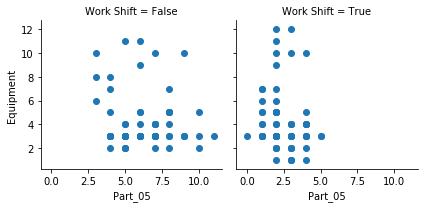

In [7]:
c=sns.FacetGrid(MTBF_Data, col='Work Shift')
c.map(plt.scatter,'Part_05','Equipment', cmap = 'R')

### T-TEST 

**Hypothesis:** There is a difference in consumption of technical material between the works shifts
Test:
* Make T-test between works shifts for Part 05

In [8]:
team_A = MTBF_Data[MTBF_Data['Work Shift'] == True]
team_B = MTBF_Data[MTBF_Data['Work Shift'] == False]

In [9]:
from scipy.stats import ttest_ind

t, p = ttest_ind(team_A['Part_05'], team_B['Part_05'])
different = True if p < 0.01 else False

In [10]:
different, t, p

(True, -15.276452586689947, 7.508187719252198e-32)

### CASE I:

* We choose the work shift that has the lowest consumption and double it
* We make a plot with results
* Finally calculate the mean beteween results

In [11]:
double_team_A = team_A.copy()
double_team_A['Dates'] = pd.to_datetime(team_A['Dates'])

In [12]:
double_team_A = double_team_A.resample('MS', on='Dates').sum()*2
double_team_A = double_team_A.drop(columns=['Equipment', 'Work Shift'])
double_team_A .head(2)

,Part_01,Part_03,Part_05,Part_06,Part_10,Part_12
Dates,,,,,,
2019-01-01,116.0,40.0,32.0,36.0,112.0,44.0
2019-02-01,58.0,26.0,28.0,34.0,74.0,36.0


#### PLOT WHITH RESULTS

In [13]:
ERP_data['Dates'] = pd.to_datetime(ERP_data['Dates'])
ERP_data = ERP_data.set_index('Dates')
result = pd.concat([ERP_data, double_team_A], axis=1, sort=False)

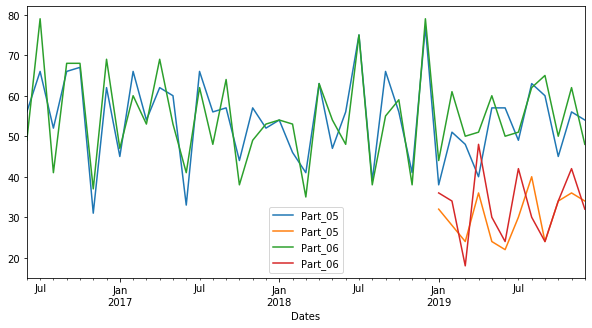

In [14]:
result.plot(y=Parts[3:5], figsize=(10,5))
plt.show()

#### THE MEAN DIFFERENCE IN PERCENTAGE

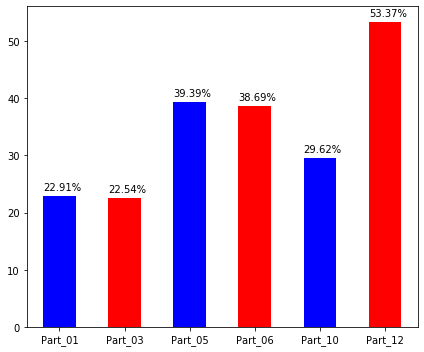

In [15]:
from decimal import Decimal
fraction_diff = double_team_A / ERP_data.iloc[31:]
mean_parts = (1 - fraction_diff.mean())*100

ax = mean_parts.plot.bar(color=['blue','red'], rot=0, figsize=(6,5))
for p in ax.patches:
    ax.annotate('{0:.2f}%'.format(Decimal(str(p.get_height()))), (p.get_x(), p.get_height()+1))
plt.tight_layout()
plt.show()

### FORECASTING CONSUMPTION REV01

* Requires Improvement

In [16]:
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset
dataframe = read_csv('ERP_Dataset.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.9)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=200, batch_size=1, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
#print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
#print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

Using TensorFlow backend.


Epoch 1/200
 - 0s - loss: 0.3170
Epoch 2/200
 - 0s - loss: 0.2614
Epoch 3/200
 - 0s - loss: 0.2165
Epoch 4/200
 - 0s - loss: 0.1782
Epoch 5/200
 - 0s - loss: 0.1482
Epoch 6/200
 - 0s - loss: 0.1247
Epoch 7/200
 - 0s - loss: 0.1091
Epoch 8/200
 - 0s - loss: 0.0983
Epoch 9/200
 - 0s - loss: 0.0910
Epoch 10/200
 - 0s - loss: 0.0879
Epoch 11/200
 - 0s - loss: 0.0841
Epoch 12/200
 - 0s - loss: 0.0821
Epoch 13/200
 - 0s - loss: 0.0809
Epoch 14/200
 - 0s - loss: 0.0801
Epoch 15/200
 - 0s - loss: 0.0794
Epoch 16/200
 - 0s - loss: 0.0785
Epoch 17/200
 - 0s - loss: 0.0771
Epoch 18/200
 - 0s - loss: 0.0767
Epoch 19/200
 - 0s - loss: 0.0762
Epoch 20/200
 - 0s - loss: 0.0749
Epoch 21/200
 - 0s - loss: 0.0743
Epoch 22/200
 - 0s - loss: 0.0739
Epoch 23/200
 - 0s - loss: 0.0731
Epoch 24/200
 - 0s - loss: 0.0724
Epoch 25/200
 - 0s - loss: 0.0722
Epoch 26/200
 - 0s - loss: 0.0707
Epoch 27/200
 - 0s - loss: 0.0703
Epoch 28/200
 - 0s - loss: 0.0697
Epoch 29/200
 - 0s - loss: 0.0690
Epoch 30/200
 - 0s - lo

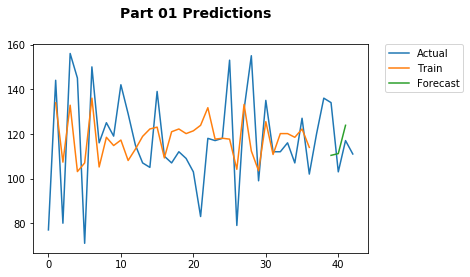

In [17]:
# plot baseline and predictions

fig = plt.figure()
ax = fig.add_subplot(111)
fig.subplots_adjust(top=0.85)

fig.suptitle('Part 01 Predictions', fontsize=14, fontweight='bold')
#ax.set_title('Part 01')


plt.plot(scaler.inverse_transform(dataset), label="Actual")
plt.plot(trainPredictPlot, label="Train")
plt.plot(testPredictPlot, label="Forecast")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()